# Total 91-106

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from catboost import Pool, CatBoostRegressor, cv
from catboost.utils import eval_metric

# Data

In [2]:
df = pd.read_stata('W:\COVID19\std_inz91_106.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [3]:
Y = df['std_inz_91to106']
X = df.loc[:, ~df.columns.isin(['std_inz_91to106', 'eastwest'])]
print("Number of features: ", len(X.columns))

Number of features:  163


# First CatBoost Model with 162 features

In [4]:
# initialize Pool
train_pool = Pool(X,Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb = model.fit(train_pool)
print("R2 of final model on all data: ",cb.score(X, Y))

R2 of final model on all data:  0.9992723219281537


In [5]:
preds = cb.predict(train_pool,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of final model on all data: ", eval_metric(Y, preds, 'RMSE')[0])

RMSE of final model on all data:  1.9582489440559467


# SHAP VAlues

In [6]:
shap_values_cb = shap.TreeExplainer(cb).shap_values(X)

invalid value encountered in true_divide
invalid value encountered in true_divide


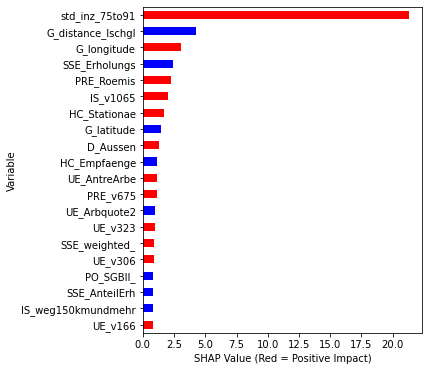

In [7]:
def ABS_SHAP(df_shap,df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[-20::]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values_cb,X) 

# Second CatBoost model with 20 most important features

In [8]:
top20feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-20:][::-1]
top10feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-10:][::-1]

In [9]:
# initialize Pool
train_pool_20 = Pool(X[top20feature],Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb_20 = model.fit(train_pool_20)
print("R2 of second model with top20 feature: ",cb_20.score(X[top20feature], Y))

R2 of second model with top20 feature:  0.9969376547845081


In [10]:
preds_20 = cb_20.predict(train_pool_20,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of second model on top20 data: ", eval_metric(Y, preds_20, 'RMSE')[0])

RMSE of second model on top20 data:  4.017217356960113


# Compare top 10 features of both Models

In [11]:
shap_values_cb_20 = shap.TreeExplainer(cb_20).shap_values(X[top20feature])

top10feature_from_top_20 = X[top20feature].columns[np.argsort(np.abs(shap_values_cb_20).mean(0))][-10:][::-1]

print("10 most important features from model with all features:", "\n", list(top10feature), "\n\n",
     "10 most important features from model with top20 features:", "\n", list(top10feature_from_top_20)) 

10 most important features from model with all features: 
 ['std_inz_75to91', 'G_distance_Ischgl', 'G_longitude', 'SSE_Erholungs', 'PRE_Roemis', 'IS_v1065', 'HC_Stationae', 'G_latitude', 'D_Aussen', 'HC_Empfaenge'] 

 10 most important features from model with top20 features: 
 ['std_inz_75to91', 'G_longitude', 'G_distance_Ischgl', 'SSE_Erholungs', 'G_latitude', 'PRE_Roemis', 'HC_Stationae', 'PRE_v675', 'UE_v323', 'IS_v1065']


In [12]:
# features which are on top10 of both models:
for i in top10feature :
    if i in list(top10feature_from_top_20) :
         print(i)

std_inz_75to91
G_distance_Ischgl
G_longitude
SSE_Erholungs
PRE_Roemis
IS_v1065
HC_Stationae
G_latitude


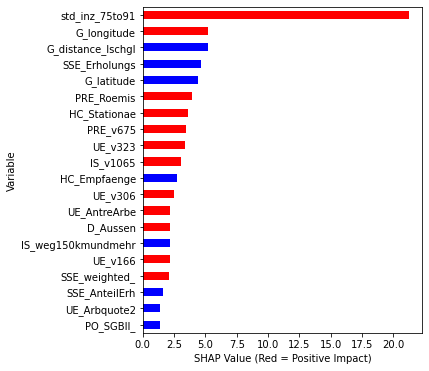

In [13]:
ABS_SHAP(shap_values_cb_20,X[top20feature]) 

# Hold out validation of the second model

In [14]:
import random
iterations = range(0,20)

r2_reg_k_test_top20 = list(range(0,20))
rmse_reg_k_test_top20 = list(range(0,20))
r2_cb_k_train_top20 = list(range(0,20))
r2_cb_k_test_top20 = list(range(0,20))

for i in iterations:
    rs = random.sample(range(0,401), 80)
    k_test_x = X[top20feature].iloc[rs]
    k_test_y = Y.iloc[rs]
    k_train_x = X[top20feature].drop(rs)
    k_train_y = Y.drop(rs)
    # initialize Pool 
    train_pool_k = Pool(data=k_train_x,
                        label=k_train_y,
                        feature_names = list(X[top20feature].columns))
        
    test_pool_k = Pool(data=k_test_x,
                       label=k_test_y,
                       feature_names = list(X[top20feature].columns))

    
    #fit the model
    model = CatBoostRegressor(random_seed=0,
                              logging_level="Silent",
                              #iterations = scores_k.sort_values(by= "test-R2-mean")["iterations"].iloc[-1]
                             )

    cb_k = model.fit(train_pool_k)
    
    # make the prediction using the resulting model
    preds_k = cb_k.predict(test_pool_k,
                    prediction_type="RawFormulaVal"
                  )
    
    rmse_reg_k_test_top20[i] = eval_metric(np.array(k_test_y), preds_k, "RMSE")[0]
    
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    reg_k = LinearRegression().fit(preds_k, k_test_y)

    
    r2_cb_k_train_top20[i] = cb_k.score(train_pool_k)
    r2_reg_k_test_top20[i] = reg_k.score(preds_k, k_test_y)

    r2_cb_k_test_top20[i] =  cb_k.score(test_pool_k)
    
    print(i/len(iterations)*100,"%", "  " , end="")

0.0 %   5.0 %   10.0 %   15.0 %   20.0 %   25.0 %   30.0 %   35.0 %   40.0 %   45.0 %   50.0 %   55.00000000000001 %   60.0 %   65.0 %   70.0 %   75.0 %   80.0 %   85.0 %   90.0 %   95.0 %   

In [15]:
print("Mean R2 of CatBoost_models on train sets with top20 features:",sum(r2_cb_k_train_top20)/len(r2_cb_k_train_top20))
print("Mean R2 of linReg_modesl with top20 features: ", sum(r2_reg_k_test_top20)/len(r2_reg_k_test_top20))
print("Mean RMSE of CatBoost_models on test sets with top20 features: ", sum(rmse_reg_k_test_top20)/len(rmse_reg_k_test_top20))
print("Mean R2 of CatBoost_models on test sets with top20 features:",sum(r2_cb_k_test_top20)/len(r2_cb_k_test_top20))

Mean R2 of CatBoost_models on train sets with top20 features: 0.9977364204203539
Mean R2 of linReg_modesl with top20 features:  0.7006408522953376
Mean RMSE of CatBoost_models on test sets with top20 features:  44.409130957377094
Mean R2 of CatBoost_models on test sets with top20 features: 0.6625948453099577


# descriptives of top20 features

In [16]:
X[top20feature].describe()

,std_inz_75to91,G_distance_Ischgl,G_longitude,SSE_Erholungs,PRE_Roemis,IS_v1065,HC_Stationae,G_latitude,D_Aussen,HC_Empfaenge,UE_AntreArbe,PRE_v675,UE_Arbquote2,UE_v323,SSE_weighted_,UE_v306,PO_SGBII_,SSE_AnteilErh,IS_weg150kmundmehr,UE_v166
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,79.461769,431.346405,9.866996,70.509460,32.242809,21.925186,24.358610,50.615292,4.806734,50.857368,9.834411,16.566586,5.356359,27.421446,0.676074,-6.157606,8.995763,2.489026,4.412467,38.296268
std,64.122574,187.236847,2.026269,56.734707,24.361435,15.378859,5.373881,1.740311,6.630641,6.518343,2.016845,5.035090,2.412844,9.129767,0.382720,22.530605,4.146994,2.681488,1.354011,7.717488
min,2.714423,56.052784,6.083333,14.000000,1.700000,0.000000,11.100000,47.500000,-13.900000,28.600000,3.000000,6.900000,1.500000,6.500000,0.143572,-69.900002,2.200000,0.300000,2.000000,15.700000
25%,40.307571,291.752441,8.216666,39.700001,7.900000,13.000000,20.400000,49.283333,1.500000,46.400002,8.600000,13.000000,3.400000,20.299999,0.421747,-14.200000,5.800000,0.800000,3.500000,33.299999
50%,63.813667,420.680756,9.766666,52.799999,29.100000,21.000000,23.700001,50.549999,3.700000,51.099998,10.200000,16.100000,5.000000,27.200001,0.583280,-7.700000,8.500000,1.300000,4.000000,38.599998
75%,99.633545,569.178772,11.416667,76.699997,52.299999,32.000000,27.500000,51.849998,6.000000,55.599998,11.200000,19.700001,6.700000,34.000000,0.811219,-0.800000,11.100000,3.000000,5.200000,43.299999
max,671.134949,866.911194,14.983334,384.600006,87.800003,79.000000,43.299999,54.783333,65.900002,66.699997,14.800000,38.000000,14.000000,54.000000,3.392816,329.000000,23.799999,13.400000,9.100000,68.300003


In [17]:
pd.DataFrame(Y).describe()

,std_inz_91to106
count,401.000000
mean,79.007408
std,72.684265
min,3.607589
25%,34.004898
50%,56.944515
75%,107.506599
max,721.384521
